In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 31% 187M/612M [00:01<00:03, 136MB/s]

In [ ]:
!unzip /content/gtsrb-german-traffic-sign.zip

Archive:  /content/gtsrb-german-traffic-sign.zip
replace Meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

## Assigning Path for Dataset

In [ ]:
data_dir = '/content'
train_path = '/content/Train'
test_path = '/content/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

## Visualizing The Dataset

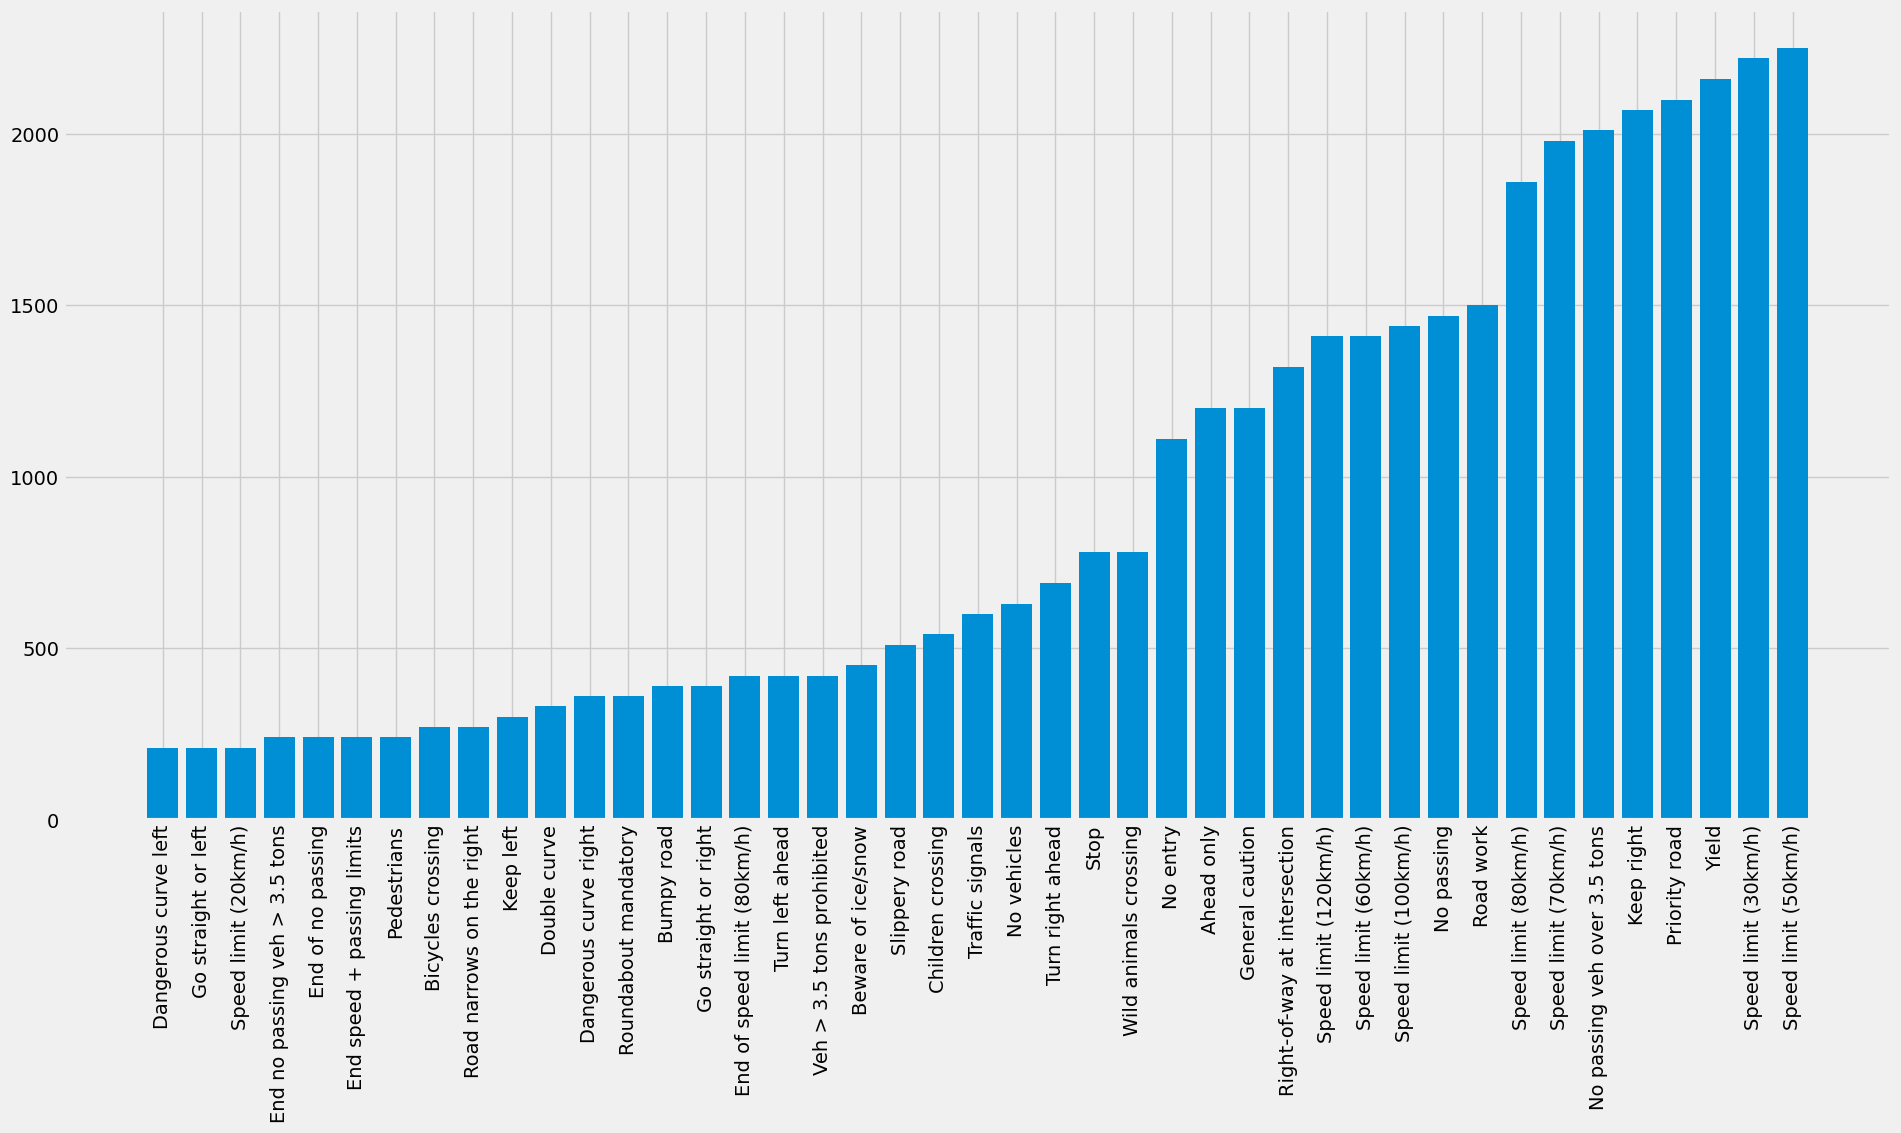

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

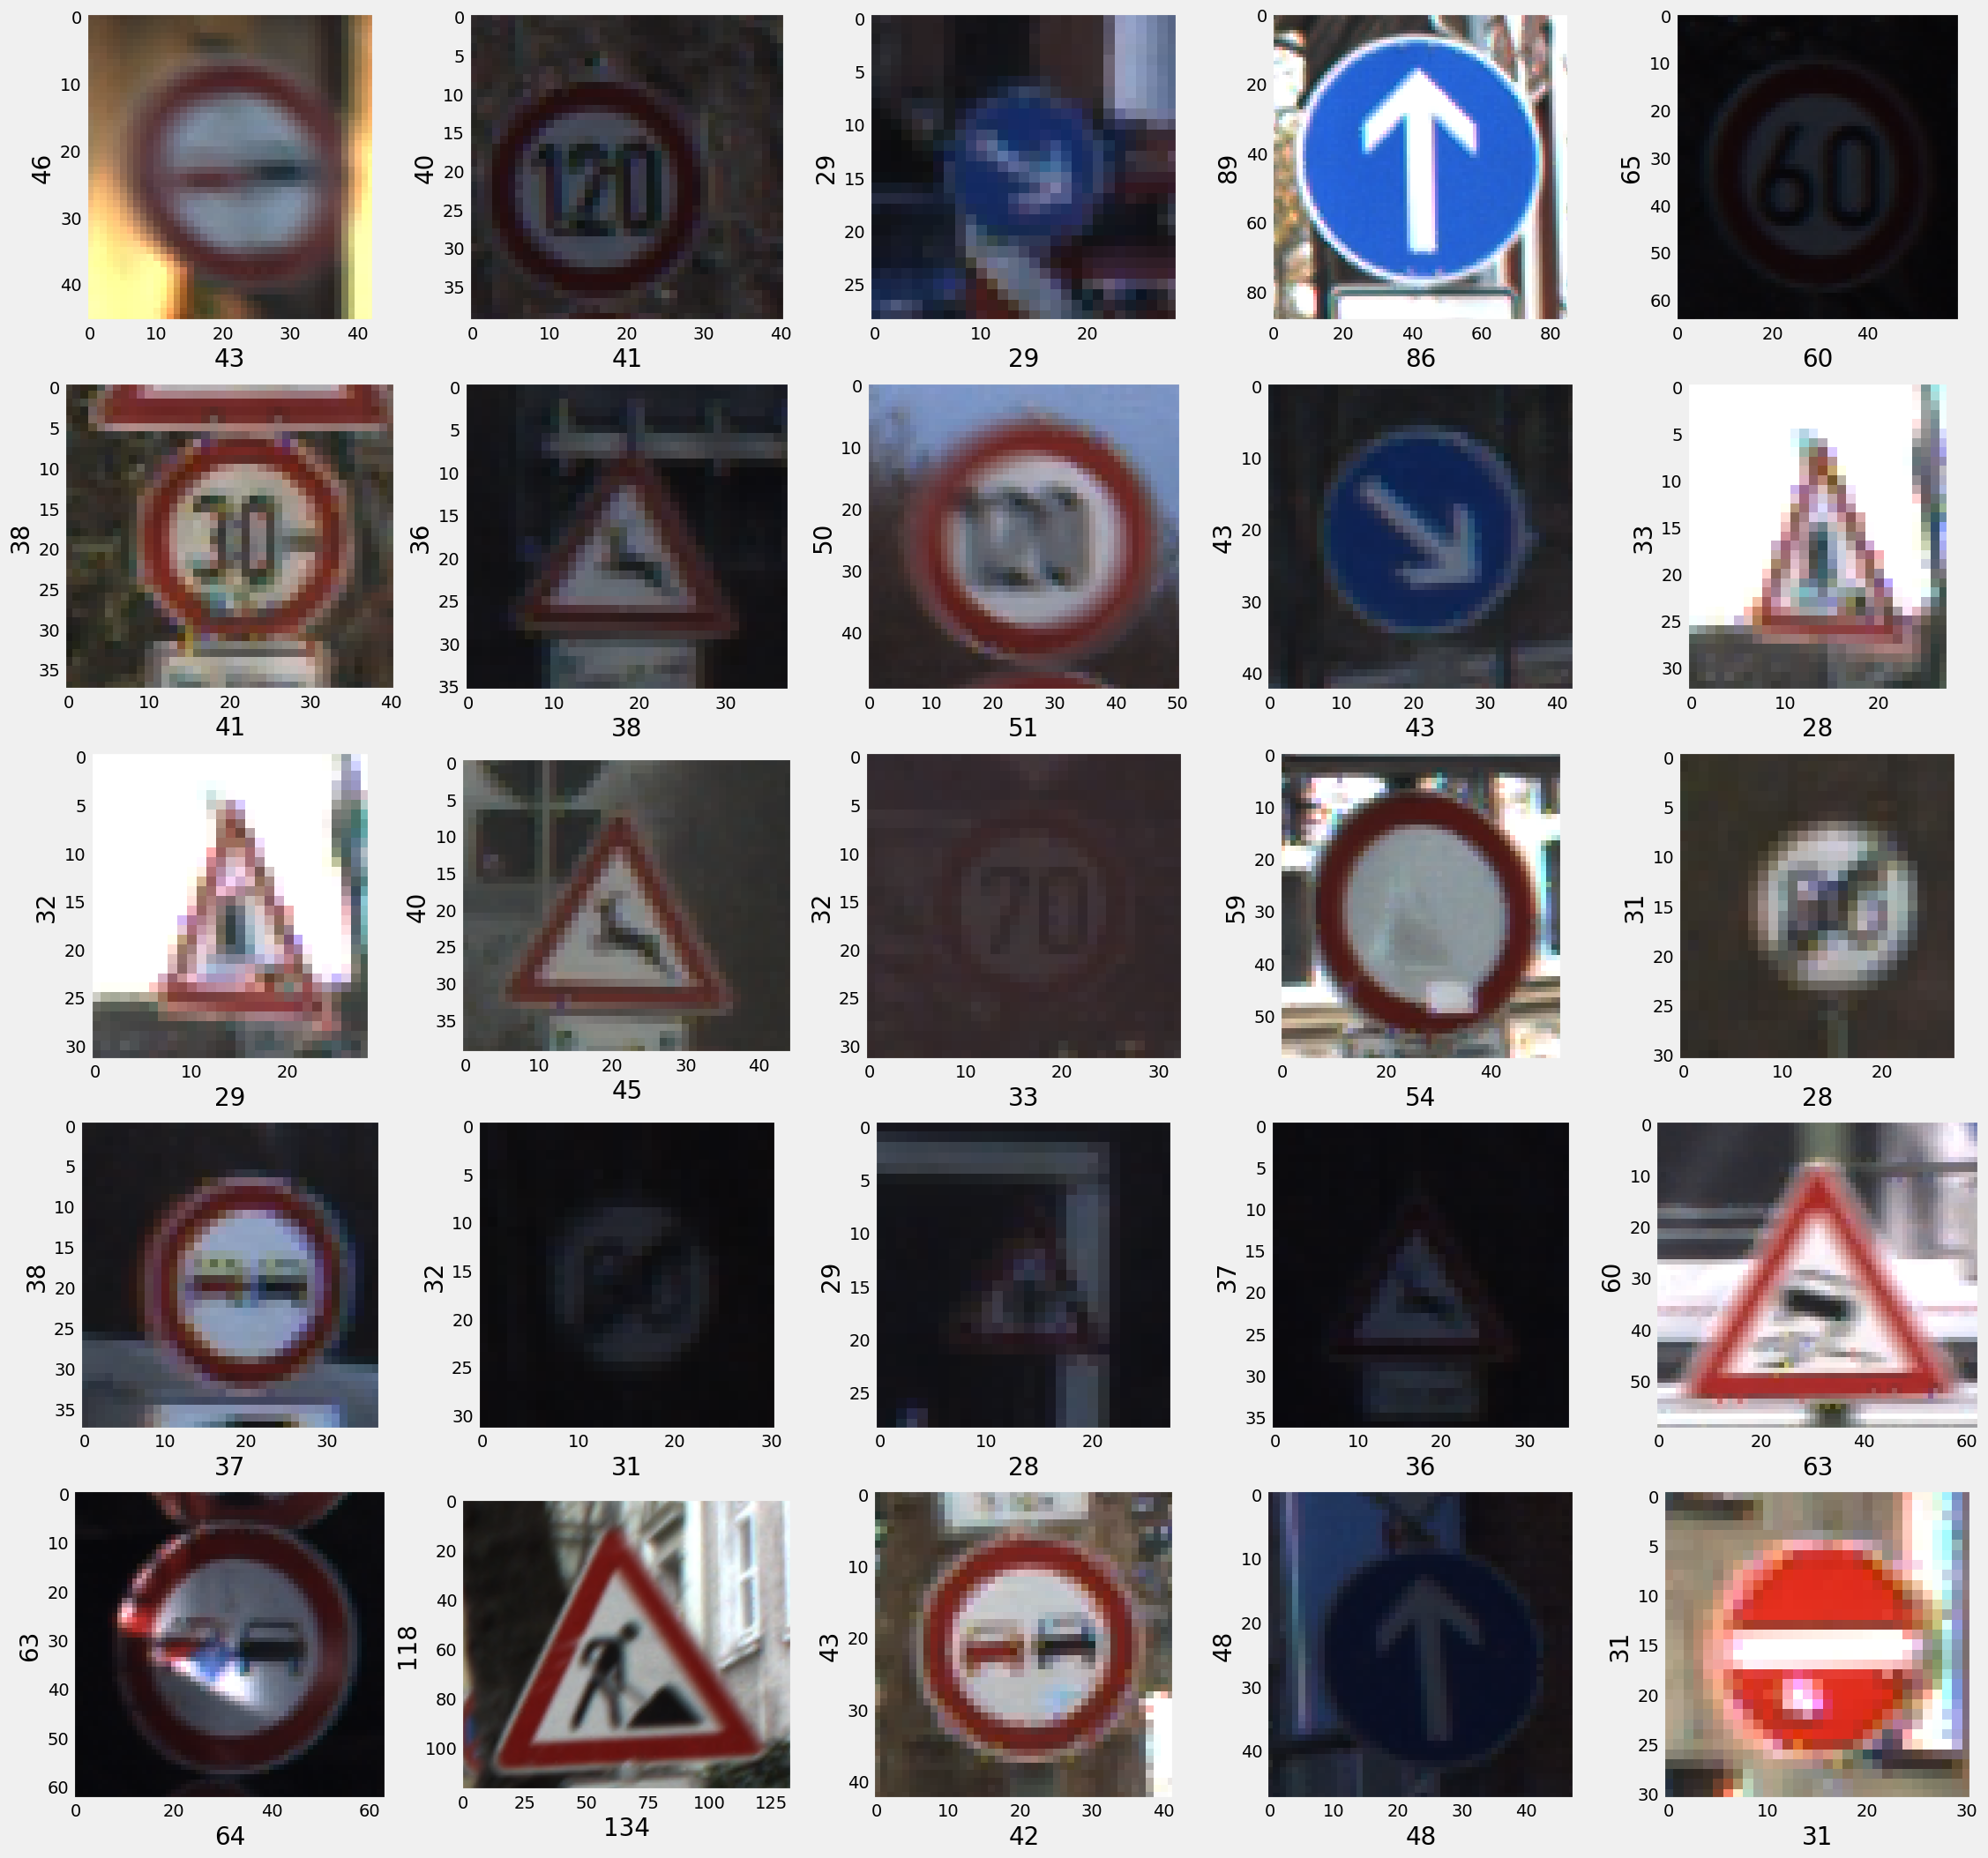

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25, 25))

for i in range(1, 26):
    plt.subplot(5, 5, i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(False)  # Disable the grid
    plt.xlabel(rand_img.shape[1], fontsize=20)  # Width of image
    plt.ylabel(rand_img.shape[0], fontsize=20)  # Height of image

plt.show()


## Collecting the Training Data

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

In [ ]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]

## Splitting the data into train and validation set

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding the labels

In [ ]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Making the model

In [ ]:
from tensorflow.keras import regularizers
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(43, activation='softmax')
])

In [ ]:
from keras.optimizers import Adam

lr = 0.001
epochs = 10
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Augmenting the data and training the model

In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")


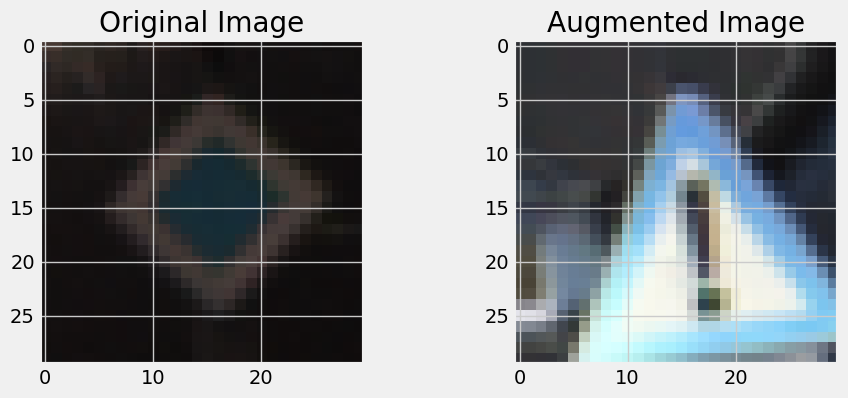

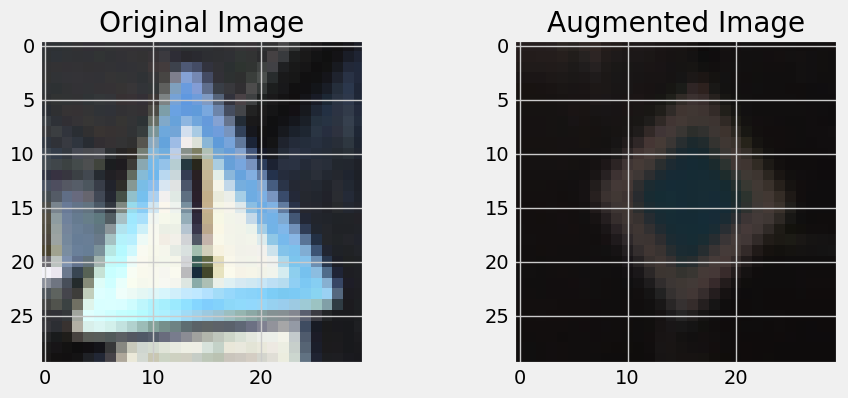

In [ ]:
import matplotlib.pyplot as plt

# Number of augmented images to visualize
num_images_to_visualize = 2

# Get a batch of augmented images
augmented_images, _ = next(aug.flow(X_train[:num_images_to_visualize], y_train[:num_images_to_visualize], batch_size=num_images_to_visualize))

# Plot the original and augmented images side by side
for i in range(num_images_to_visualize):
    plt.figure(figsize=(10, 4))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i])
    plt.title("Original Image")

    # Augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_images[i])
    plt.title("Augmented Image")

    plt.show()


In [ ]:
history = model.fit(aug.flow(X_train, y_train, batch_size=32),
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Epoch 1/10
858/858 [==============================] - 27s 29ms/step - loss: 2.5956 - accuracy: 0.3001 - val_loss: 1.3738 - val_accuracy: 0.6225
Epoch 2/10
858/858 [==============================] - 23s 26ms/step - loss: 1.6508 - accuracy: 0.5314 - val_loss: 0.8887 - val_accuracy: 0.8034
Epoch 3/10
858/858 [==============================] - 21s 24ms/step - loss: 1.3432 - accuracy: 0.6276 - val_loss: 0.7125 - val_accuracy: 0.8545
Epoch 4/10
858/858 [==============================] - 21s 25ms/step - loss: 1.1647 - accuracy: 0.6909 - val_loss: 0.5867 - val_accuracy: 0.9020
Epoch 5/10
858/858 [==============================] - 22s 25ms/step - loss: 1.0499 - accuracy: 0.7276 - val_loss: 0.5068 - val_accuracy: 0.9288
Epoch 6/10
858/858 [==============================] - 22s 26ms/step - loss: 0.9681 - accuracy: 0.7574 - val_loss: 0.4454 - val_accuracy: 0.9503
Epoch 7/10
858/858 [==============================] - 22s 25ms/step - loss: 0.8926 - accuracy: 0.7847 - val_loss: 0.3955 - val_accuracy:

## Evaluating the model

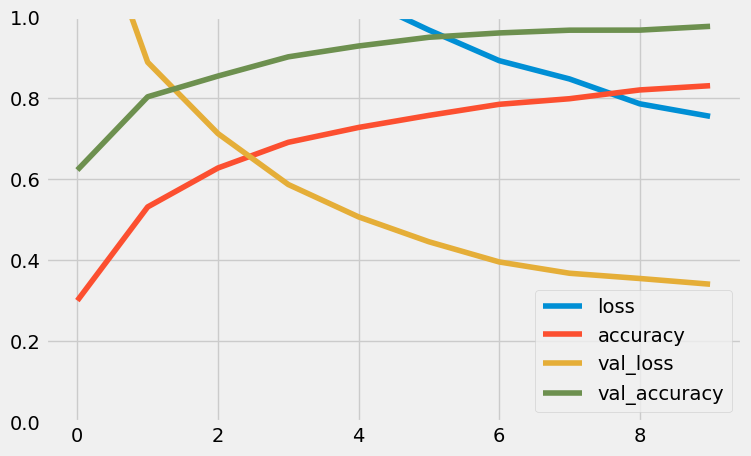

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Loading the test data and running the predictions

In [ ]:
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data = []

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)

X_test = np.array(data)
X_test = X_test / 255

# Use the predict method instead of predict_classes
pred_probabilities = model.predict(X_test)
pred = np.argmax(pred_probabilities, axis=1)

# Accuracy with the test data
print('Test Data accuracy: ', accuracy_score(labels, pred) * 100)


395/395 [==============================] - 1s 3ms/step
Test Data accuracy:  93.05621536025338


## Visualizing the confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

<Axes: >

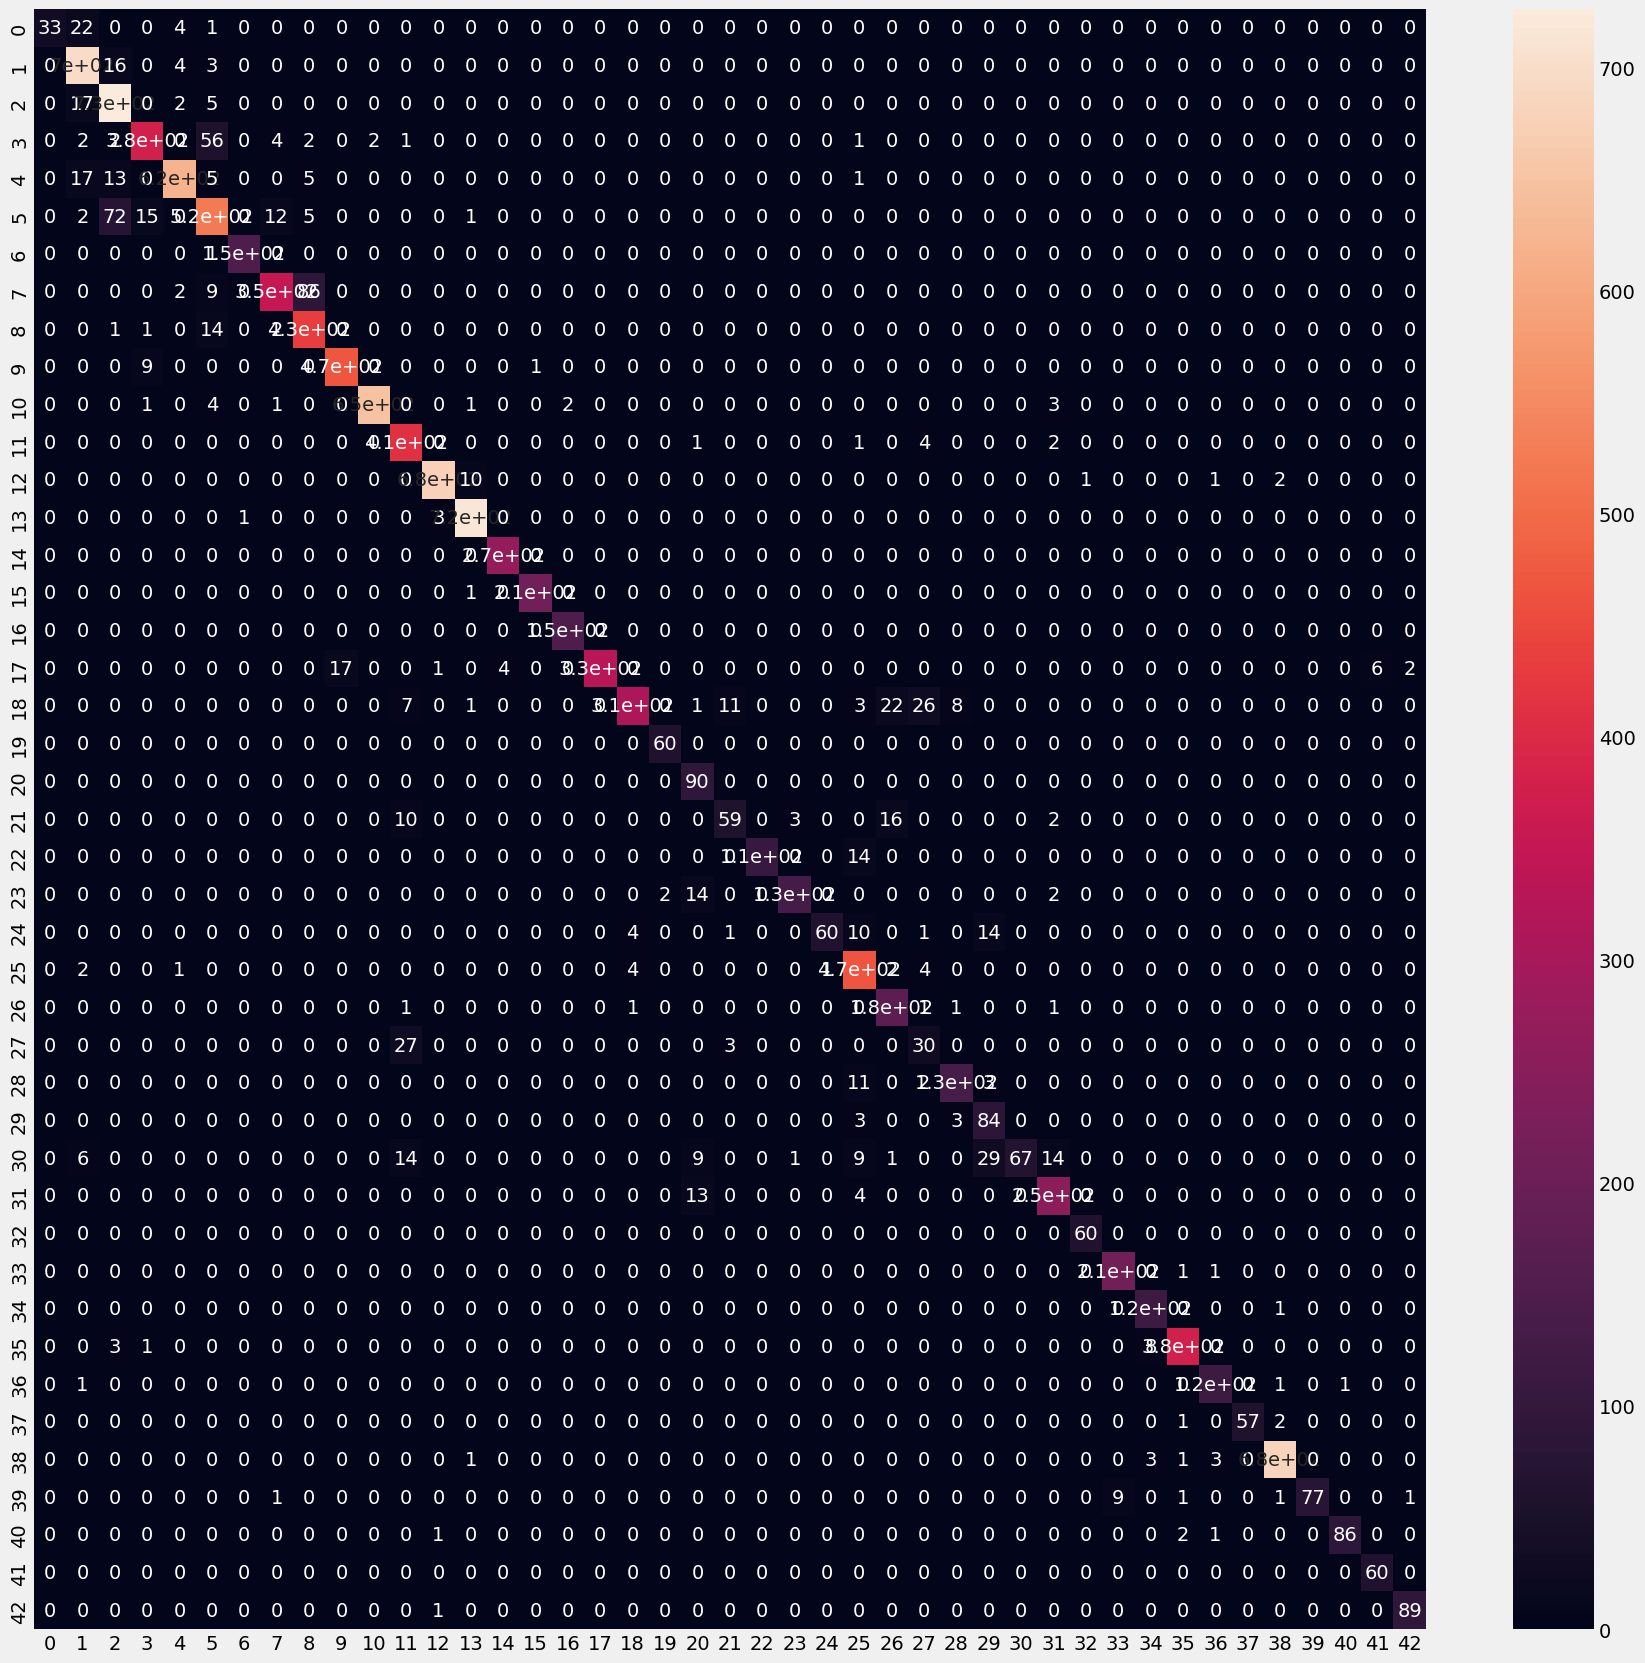

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      0.55      0.71        60
           1       0.91      0.97      0.94       720
           2       0.87      0.97      0.92       750
           3       0.93      0.84      0.89       450
           4       0.98      0.94      0.96       660
           5       0.84      0.83      0.84       630
           6       0.99      0.99      0.99       150
           7       0.95      0.78      0.86       450
           8       0.82      0.96      0.88       450
           9       0.97      0.98      0.97       480
          10       1.00      0.98      0.99       660
          11       0.87      0.98      0.92       420
          12       0.99      0.98      0.99       690
          13       0.98      0.99      0.99       720
          14       0.99      1.00      0.99       270
          15       1.00      1.00      1.00       210
          16       0.99      1.00      0.99       150
          17       1.00    

## Predictions on Test Data

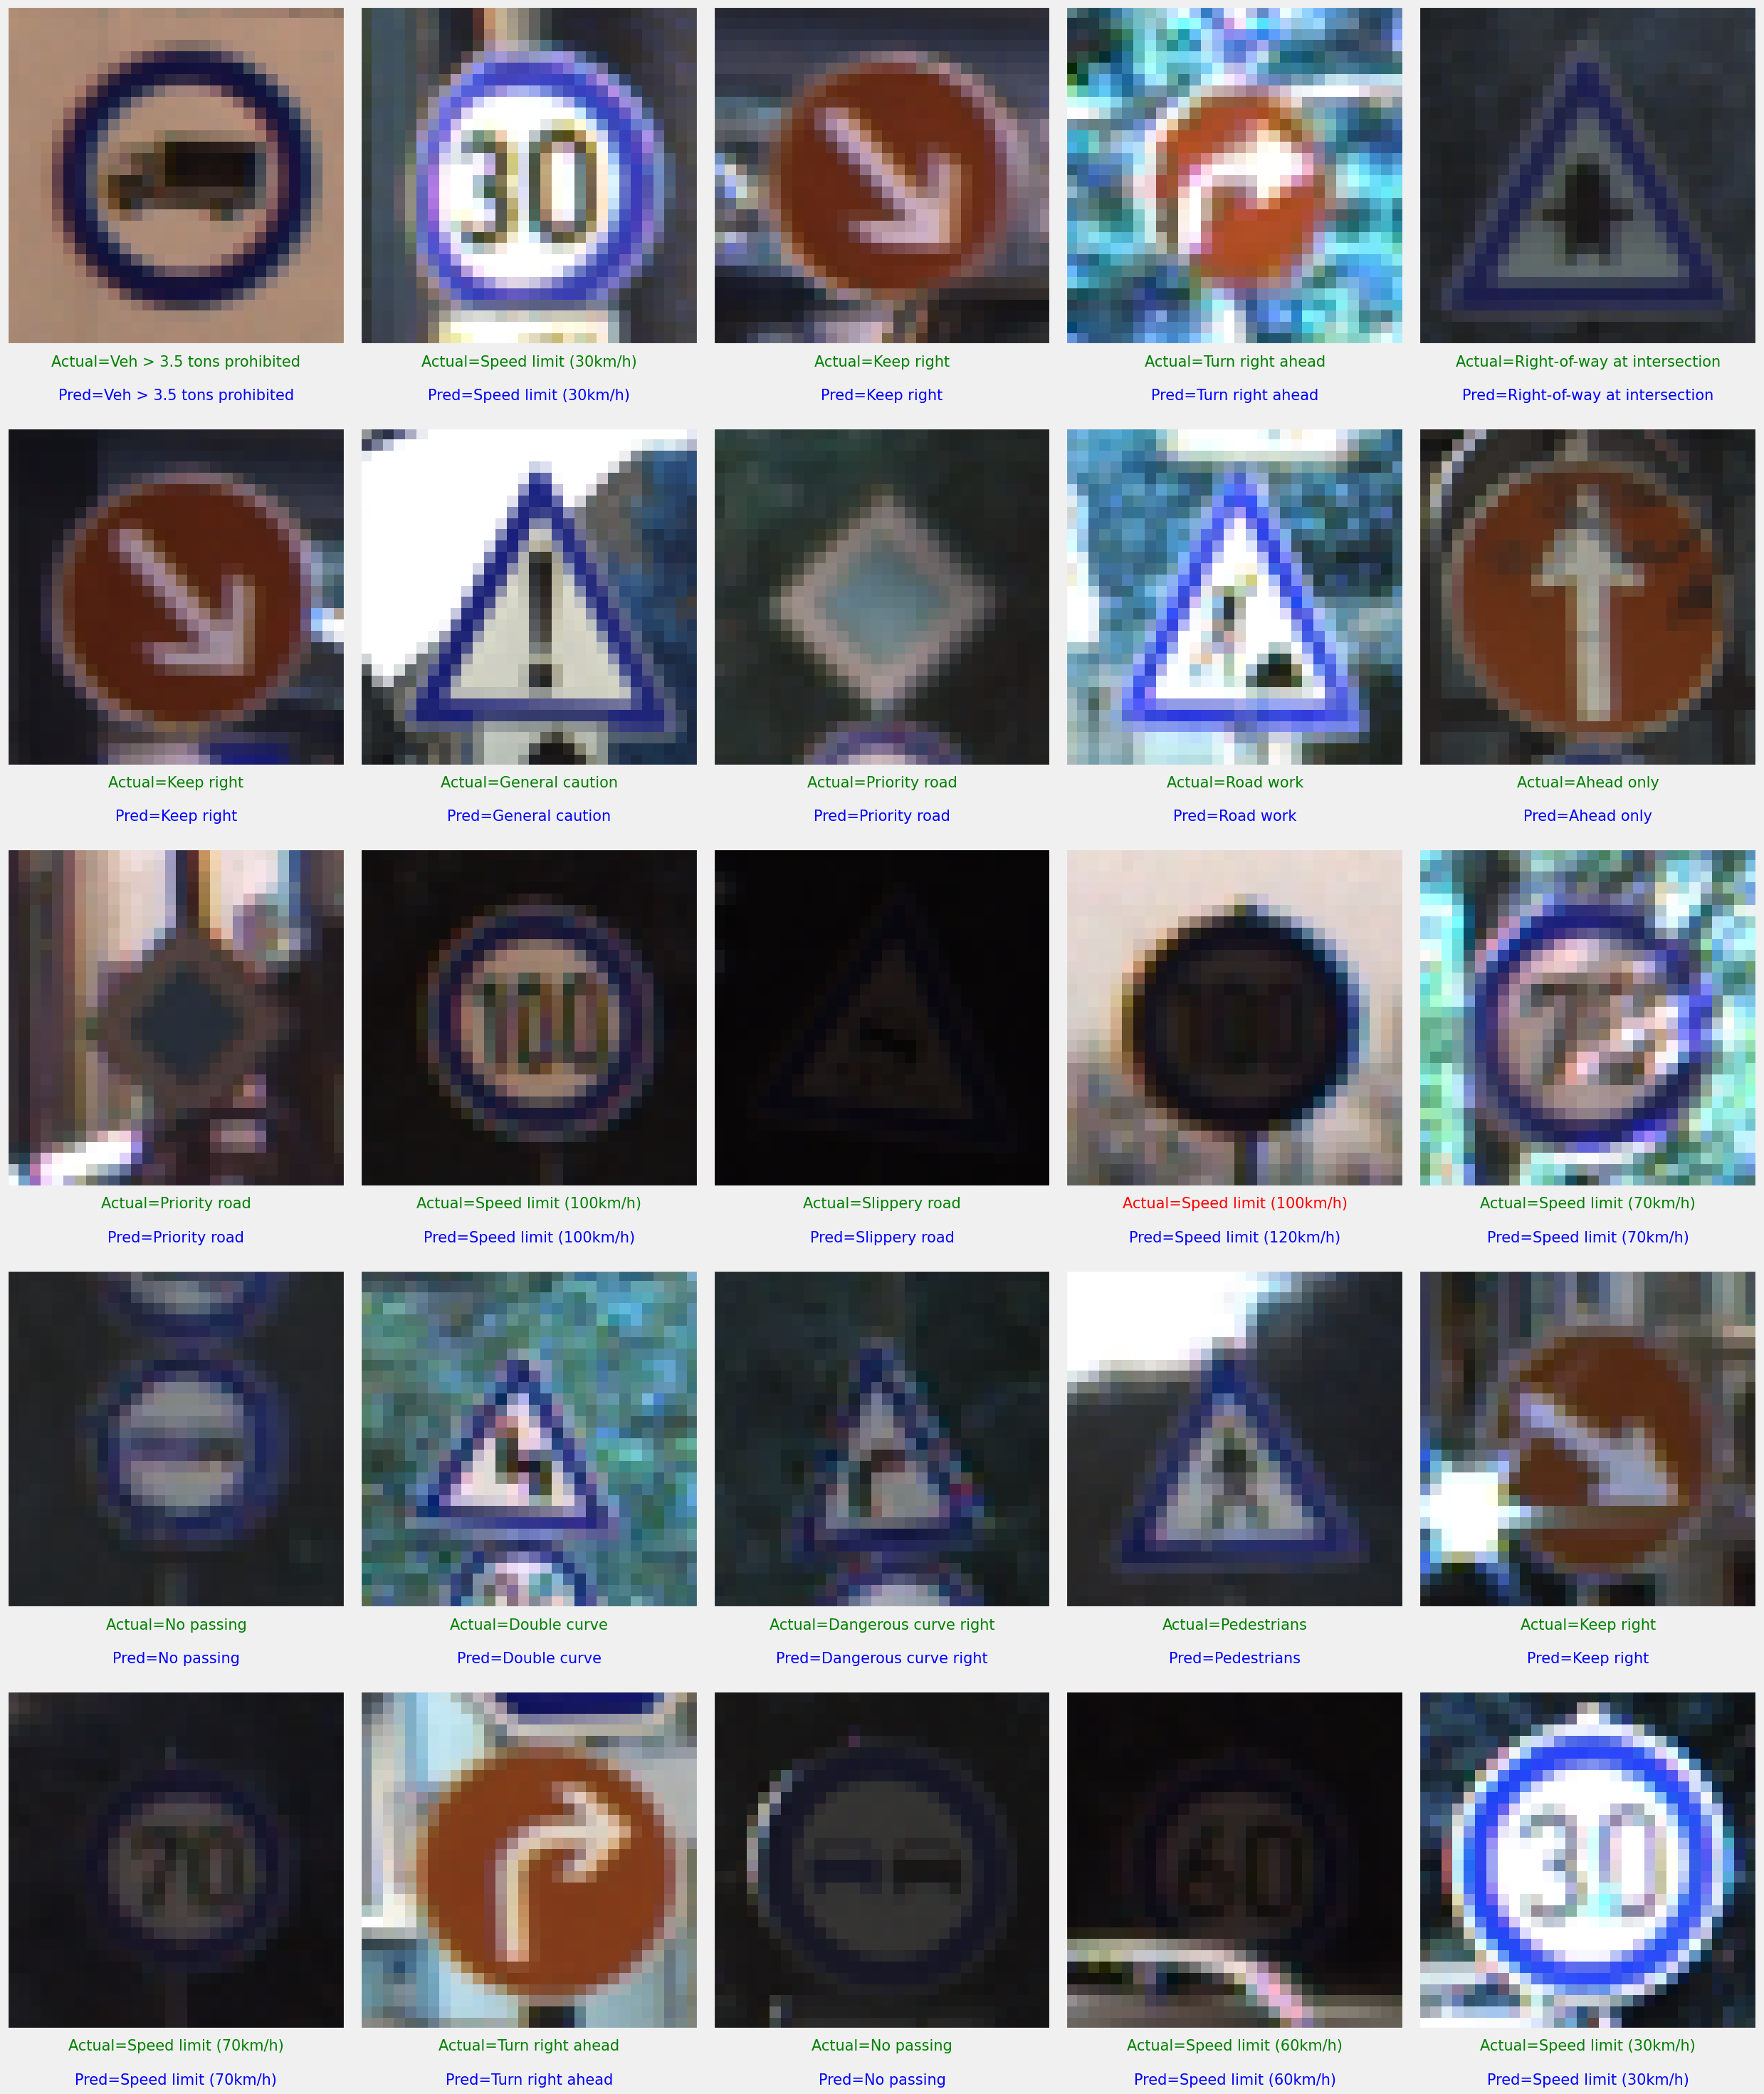

In [ ]:
plt.figure(figsize=(25, 30))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    prediction = classes[pred[start_index + i]]
    actual = classes[labels[start_index + i]]

    col = 'g'
    if prediction != actual:
        col = 'r'

    plt.imshow(X_test[start_index + i])

    plt.text(0.5, -0.05, 'Actual={}'.format(actual), color=col, fontsize=15,
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.text(0.5, -0.15, 'Pred={}'.format(prediction), color='b', fontsize=15,
             ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 81ms/step


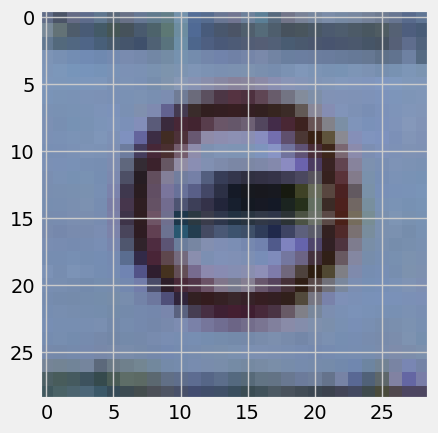

Predicted class: Veh > 3.5 tons prohibited


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load and preprocess a single image for prediction
img_path = '/content/test/00999.png'
img = image.load_img(img_path, target_size=(30, 30))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize pixel values to the range [0, 1]

# Make predictions
predictions = model.predict(img_array)

# Decode predictions to human-readable class labels
predicted_class = np.argmax(predictions)

# Load the image
img = Image.open(img_path)

# Display the image
plt.imshow(img)
plt.show()

print(f"Predicted class: {classes[predicted_class]}")
